In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/exchange_rate.csv')
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [3]:
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [8]:
df = pd.read_csv('/content/exchange_rate.csv', parse_dates=['date']) # Changed 'Date' to 'date' to match the actual column name

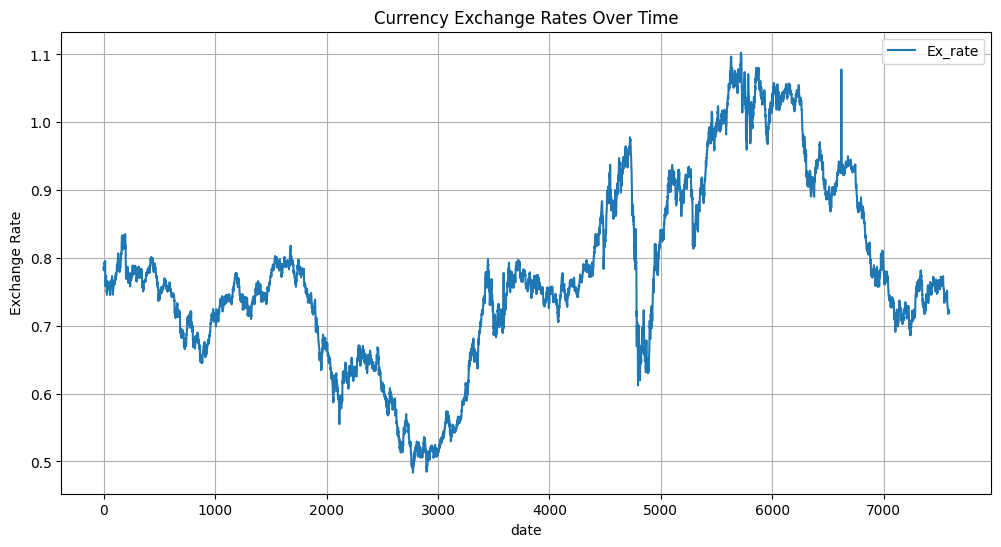

In [12]:
# Assuming 'Currency' is the column with currency names and 'Rate' is the exchange rate column
plt.figure(figsize=(12, 6))
sns.lineplot(data=df)
plt.title('Currency Exchange Rates Over Time')
plt.xlabel('date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

In [14]:
df['Ex_rate'] = df['Ex_rate'].fillna(df['Ex_rate'].mean())

In [16]:
df.dropna(subset=['Ex_rate'], inplace=True)

In [17]:
df['Rate_Smoothed'] = df['Ex_rate'].rolling(window=7).mean()

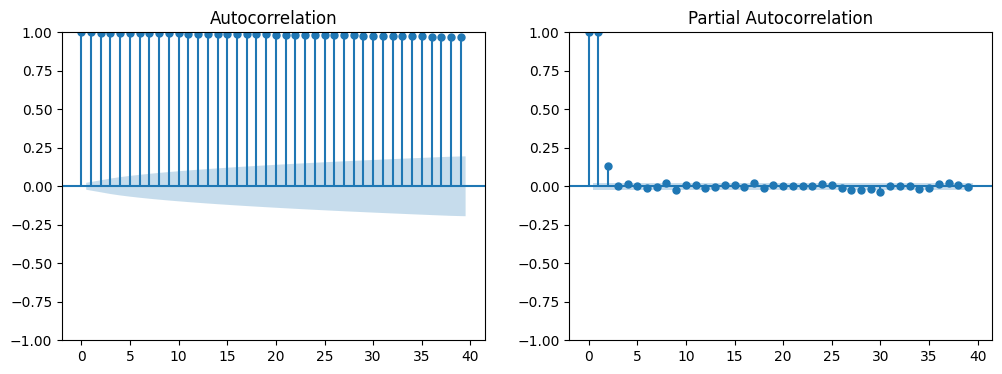

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'Rate' is the column with exchange rate values for a specific currency
# Replace 'CurrencyName' with the actual currency name

currency_data = df['Ex_rate']

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(currency_data, ax=axes[0])
plot_pacf(currency_data, ax=axes[1])
plt.show()

In [21]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'currency_data' is the preprocessed time series for a specific currency
# and p, d, q are the estimated parameters
p = 1  # Autoregressive order
d = 1  # Integrated order
q = 1
model = ARIMA(currency_data, order=(p, d, q))  # Replace p, d, q with your values
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 28 Oct 2024   AIC                         -56102.322
Time:                        16:37:14   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

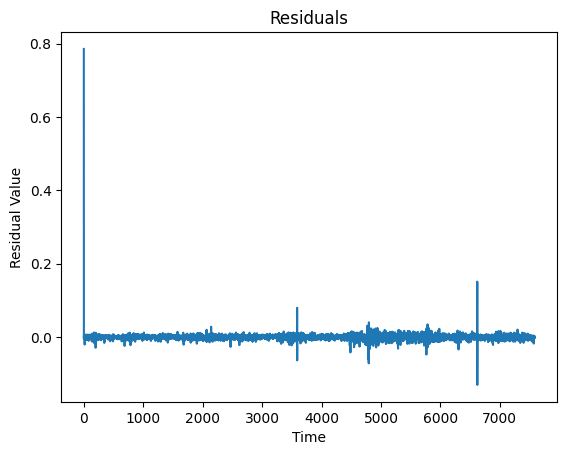

    lb_stat  lb_pvalue
10  1.81673   0.997562


In [22]:
# Get the residuals from the fitted model
residuals = model_fit.resid

# Plot the residuals
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.show()

# Perform statistical tests on the residuals
# (e.g., Ljung-Box test for autocorrelation)
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(residuals, lags=[10])  # Test for up to 10 lags
print(ljung_box_results)

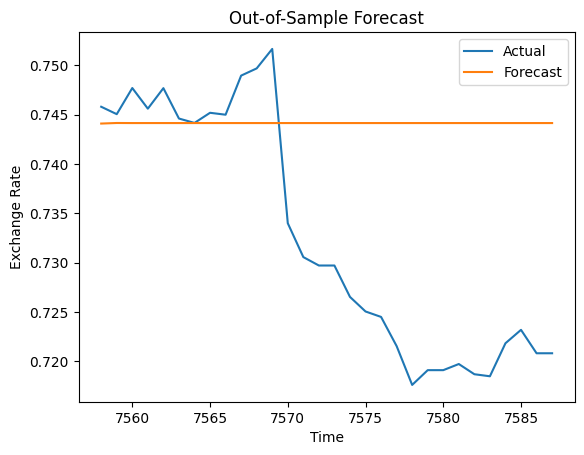

In [23]:
# Split the data into training and testing sets
train_data = currency_data[:-30]  # Use data up to 30 points before the end for training
test_data = currency_data[-30:]   # Use the last 30 points for testing

# Fit the ARIMA model to the training data
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

# Forecast the next 30 steps
forecast = model_fit.predict(start=len(train_data), end=len(currency_data)-1)

# Visualize the forecast against actual values
plt.plot(test_data.index, test_data.values, label='Actual')
plt.plot(test_data.index, forecast, label='Forecast')
plt.title('Out-of-Sample Forecast')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [24]:
# Assuming 'currency_data' is the preprocessed time series for a specific currency

# If no trend or seasonality is observed:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(currency_data)

# If a trend is observed but no seasonality:
from statsmodels.tsa.holtwinters import Holt

model = Holt(currency_data)

# If both trend and seasonality are observed:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(currency_data, seasonal_periods=12, # Example: 12 for monthly seasonality
                                 trend='add', seasonal='add') # Choose appropriate trend and seasonal components

In [25]:
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define parameter grid for grid search
param_grid = {
    'smoothing_level': [0.1, 0.2, 0.3],
    'smoothing_slope': [0.05, 0.1, 0.15],  # For Holt's Linear or Holt-Winters with trend
    'smoothing_seasonal': [0.1, 0.2, 0.3],  # For Holt-Winters with seasonality
    'seasonal_periods': [7, 12],  # For Holt-Winters with seasonality
}

# Perform grid search
best_aic = float('inf')
best_params = {}

for params in ParameterGrid(param_grid):
    try:
        model = ExponentialSmoothing(currency_data, **params)
        model_fit = model.fit()
        aic = model_fit.aic

        if aic < best_aic:
            best_aic = aic
            best_params = params

    except:
        continue

print("Best AIC:", best_aic)
print("Best Parameters:", best_params)

Best AIC: inf
Best Parameters: {}


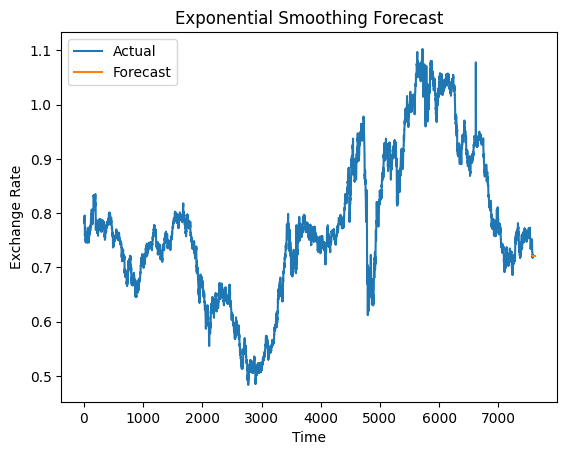

In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assuming 'best_params' contains the optimal parameters from the previous step
model = ExponentialSmoothing(currency_data, **best_params)
model_fit = model.fit()

# Forecast future values
forecast = model_fit.forecast(steps=30)  # Forecast for the next 30 periods

# Visualize the forecast against actual data
plt.plot(currency_data.index, currency_data.values, label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast')
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np # Import numpy

# ... (Previous code for fitting ARIMA and Exponential Smoothing models) ...

# Assuming 'test_data' contains the actual values for the testing period
# and 'forecast' from ipython-input-23-bb9e65f8cc02 contains the forecasts from ARIMA
# and 'forecast' from ipython-input-26-bb9e65f8cc02 contains the forecasts from Exponential Smoothing, respectively

# Rename 'forecast' from previous cells to 'forecast_arima' and 'forecast_es'
forecast_arima = forecast # From ARIMA model in ipython-input-23-bb9e65f8cc02
forecast_es = forecast # From Exponential Smoothing in ipython-input-26-bb9e65f8cc02

# Calculate MAE
mae_arima = mean_absolute_error(test_data, forecast_arima)
mae_es = mean_absolute_error(test_data, forecast_es)

# Calculate RMSE
rmse_arima = mean_squared_error(test_data, forecast_arima, squared=False)  # squared=False for RMSE
rmse_es = mean_squared_error(test_data, forecast_es, squared=False)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_arima = mean_absolute_percentage_error(test_data, forecast_arima)
mape_es = mean_absolute_percentage_error(test_data, forecast_es)

# Print the error metrics
print("ARIMA - MAE:", mae_arima, "RMSE:", rmse_arima, "MAPE:", mape_arima)
print("Exponential Smoothing - MAE:", mae_es, "RMSE:", rmse_es, "MAPE:", mape_es)

ARIMA - MAE: 0.012707429455384294 RMSE: 0.016957814302365717 MAPE: nan
Exponential Smoothing - MAE: 0.012707429455384294 RMSE: 0.016957814302365717 MAPE: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
